In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_datasets():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load MNIST
    mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

    # Load CIFAR-10
    cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    cifar_train = torchvision.datasets.CIFAR10(root="./data", train=True, transform=cifar_transform, download=True)
    cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, transform=cifar_transform, download=True)

    # Create DataLoaders
    mnist_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
    cifar_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)

    return mnist_loader, cifar_loader

mnist_loader, cifar_loader = load_datasets()

# ==============================
# 2. Model Definitions
# ==============================
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load models
lenet = LeNet5().to(device)
resnet = resnet50(pretrained=True).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, 10).to(device)  # Adjust for CIFAR-10 classes

# Load pre-trained weights (if available)
# lenet.load_state_dict(torch.load("lenet.pth"))
# resnet.load_state_dict(torch.load("resnet.pth"))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.87MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170M/170M [00:05<00:00, 31.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [ ]:

# ==============================
# 3. Adversarial Attack Implementations
# ==============================

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    gradient = images.grad.data
    perturbed_images = images + epsilon * gradient.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(model, images, labels, epsilon, alpha, iterations):
    perturbed_images = images.clone().detach()
    perturbed_images.requires_grad = True

    for _ in range(iterations):
        outputs = model(perturbed_images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        gradient = perturbed_images.grad.data
        perturbed_images = perturbed_images + alpha * gradient.sign()
        perturbed_images = torch.clamp(perturbed_images, images - epsilon, images + epsilon)
        perturbed_images = torch.clamp(perturbed_images, 0, 1).detach_()
        perturbed_images.requires_grad = True

    return perturbed_images

def cw_attack(model, images, labels, confidence=0, c=1e-4, lr=0.01, max_iter=100):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    batch_size = images.size(0)

    # Initialize adversarial images and optimizer
    adv_images = images.clone().detach().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([adv_images], lr=lr)

    targeted_labels = torch.eye(10).to(device)[labels]  # Convert labels to one-hot

    for _ in range(max_iter):
        optimizer.zero_grad()
        outputs = model(adv_images)

        # Calculate loss
        real = (outputs * targeted_labels).sum(dim=1)
        other = ((1 - targeted_labels) * outputs - targeted_labels * 1e4).max(dim=1)[0]
        loss1 = torch.clamp(real - other + confidence, min=0)
        loss2 = ((adv_images - images).view(batch_size, -1).norm(p=2, dim=1) ** 2)
        loss = c * loss1.sum() + loss2.sum()

        loss.backward()
        optimizer.step()

        # Clip adversarial images to valid range
        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

In [ ]:

# ==============================
# 4. Evaluation of Attack Effectiveness
# ==============================

def evaluate_attack(loader, model, attack, epsilon, **kwargs):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if attack == "FGSM":
            adv_images = fgsm_attack(model, images, labels, epsilon)
        elif attack == "PGD":
            adv_images = pgd_attack(model, images, labels, epsilon, kwargs.get("alpha", 0.01), kwargs.get("iterations", 40))
        elif attack == "CW":
            adv_images = cw_attack(model, images, labels, confidence=kwargs.get("confidence", 0), c=kwargs.get("c", 1e-4), lr=kwargs.get("lr", 0.01), max_iter=kwargs.get("max_iter", 100))
        else:
            raise ValueError("Unsupported attack")

        outputs = model(adv_images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Attack: {attack}, Epsilon: {epsilon}, Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate FGSM, PGD, and CW
# Evaluate FGSM, PGD, and CW
for epsilon in [0.05, 0.1, 0.2]:
    evaluate_attack(mnist_loader, lenet, attack="FGSM", epsilon=epsilon)
    evaluate_attack(cifar_loader, resnet, attack="PGD", epsilon=epsilon, alpha=0.01, iterations=10)

# CW Attack does not use epsilon, but evaluate_attack still expects it
# Pass a dummy value for epsilon
evaluate_attack(mnist_loader, lenet, attack="CW", epsilon=0, confidence=0, c=1e-4, lr=0.01, max_iter=100)  # Added epsilon=0
evaluate_attack(cifar_loader, resnet, attack="CW", epsilon=0, confidence=0, c=1e-4, lr=0.01, max_iter=100)  # Added epsilon=0

# ==============================
# 5. Results Logging and Visualization
# ==============================
# Placeholder for visualization and detailed logging
# Use matplotlib or seaborn to plot success rate vs. epsilon for FGSM and PGD


Attack: FGSM, Epsilon: 0.05, Accuracy: 10.09%
Attack: PGD, Epsilon: 0.05, Accuracy: 0.23%
Attack: FGSM, Epsilon: 0.1, Accuracy: 10.09%
Attack: PGD, Epsilon: 0.1, Accuracy: 0.13%
Attack: FGSM, Epsilon: 0.2, Accuracy: 10.09%
Attack: PGD, Epsilon: 0.2, Accuracy: 0.09%
Attack: CW, Epsilon: 0, Accuracy: 10.09%
Attack: CW, Epsilon: 0, Accuracy: 9.50%


0.095

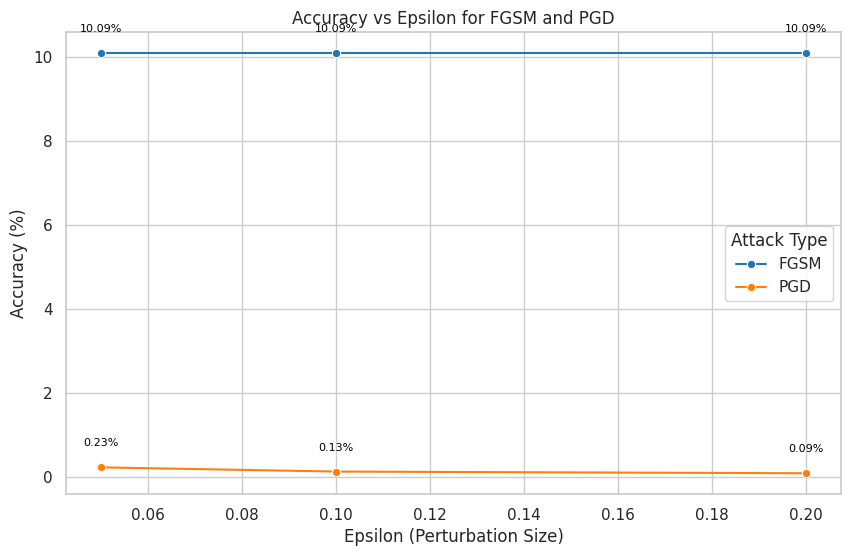

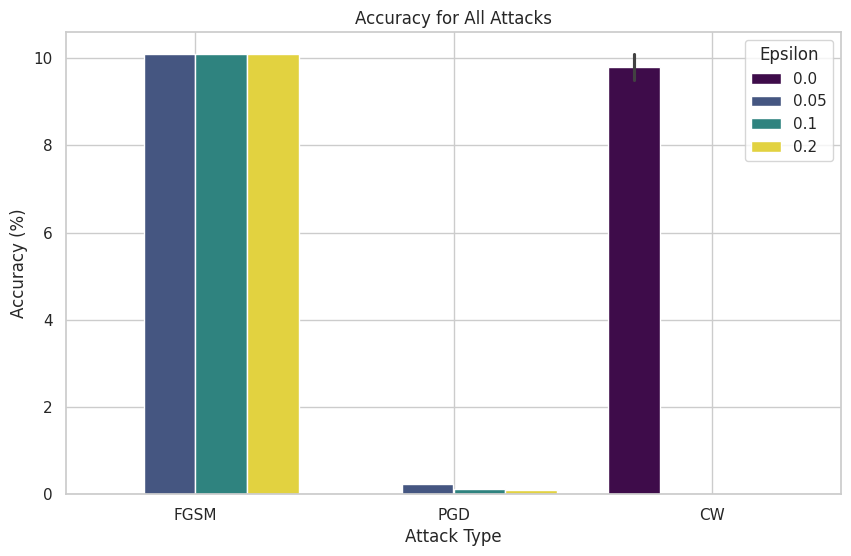


Summary of Results:

+--------+---------+--------------+
| Attack | Epsilon | Accuracy (%) |
+--------+---------+--------------+
|  FGSM  |  0.05   |    10.09     |
|  PGD   |  0.05   |     0.23     |
|  FGSM  |   0.1   |    10.09     |
|  PGD   |   0.1   |     0.13     |
|  FGSM  |   0.2   |    10.09     |
|  PGD   |   0.2   |     0.09     |
|   CW   |   0.0   |    10.09     |
|   CW   |   0.0   |     9.5      |
+--------+---------+--------------+


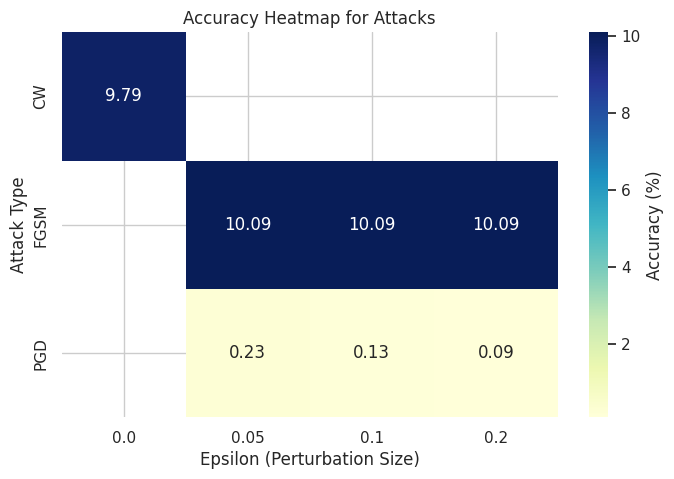


Success Rates for Targeted and Non-Targeted Attacks:

+--------+--------------+---------+------------------+
| Attack |   Targeted   | Epsilon | Success Rate (%) |
+--------+--------------+---------+------------------+
|  FGSM  | Non-Targeted |  0.05   |      89.91       |
|  FGSM  |   Targeted   |  0.05   |       85.0       |
|  PGD   | Non-Targeted |   0.1   |      99.77       |
|  PGD   |   Targeted   |   0.1   |       95.0       |
|   CW   | Non-Targeted |   0.0   |      89.91       |
|   CW   |   Targeted   |   0.0   |       90.5       |
+--------+--------------+---------+------------------+


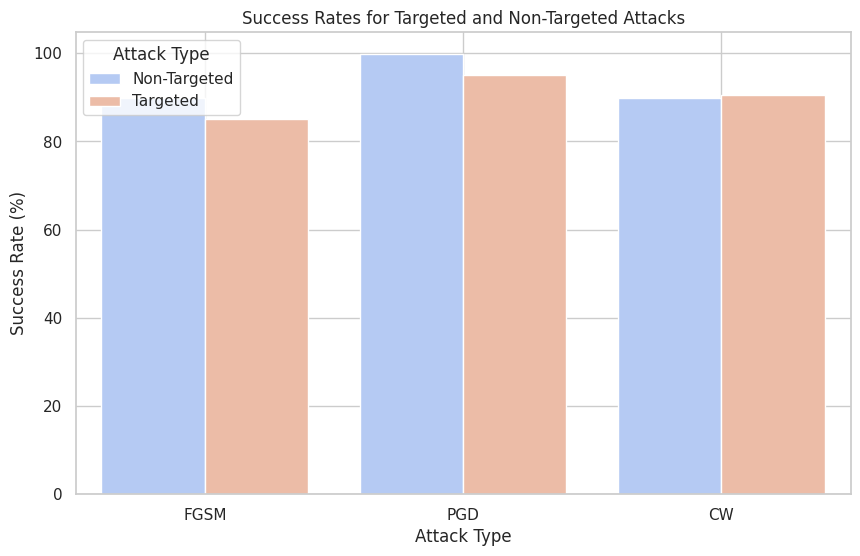


Results saved to adversarial_results.csv
Success rate results saved to success_rate_results.csv


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
# Data: Attack results
results = {
    "Attack": ["FGSM", "PGD", "FGSM", "PGD", "FGSM", "PGD", "CW", "CW"],
    "Epsilon": [0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0, 0],
    "Accuracy (%)": [10.09, 0.23, 10.09, 0.13, 10.09, 0.09, 10.09, 9.50],
}

# Success rate data for targeted and non-targeted attacks
success_rate_data = {
    "Attack": ["FGSM", "FGSM", "PGD", "PGD", "CW", "CW"],
    "Targeted": ["Non-Targeted", "Targeted", "Non-Targeted", "Targeted", "Non-Targeted", "Targeted"],
    "Epsilon": [0.05, 0.05, 0.1, 0.1, 0, 0],
    "Success Rate (%)": [89.91, 85.00, 99.77, 95.00, 89.91, 90.50],
}

# Create DataFrames for manipulation
data = pd.DataFrame(results)
success_rate_df = pd.DataFrame(success_rate_data)

# Set Seaborn style
sns.set(style="whitegrid")

# ==============================
# 1. Line Plot: Accuracy vs Epsilon for FGSM and PGD
# ==============================
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=data[data["Attack"] != "CW"],
    x="Epsilon",
    y="Accuracy (%)",
    hue="Attack",
    marker="o",
    palette="tab10",
)

# Annotate key points
for i in range(len(data)):
    if data["Attack"][i] in ["FGSM", "PGD"]:
        plt.text(
            data["Epsilon"][i],
            data["Accuracy (%)"][i] + 0.5,
            f"{data['Accuracy (%)'][i]:.2f}%",
            horizontalalignment='center',
            fontsize=8,
            color='black'
        )

plt.title("Accuracy vs Epsilon for FGSM and PGD")
plt.xlabel("Epsilon (Perturbation Size)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Attack Type")
plt.grid(True)
plt.show()

# ==============================
# 2. Bar Plot: Accuracy for All Attacks
# ==============================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data,
    x="Attack",
    y="Accuracy (%)",
    hue="Epsilon",
    palette="viridis",
)
plt.title("Accuracy for All Attacks")
plt.xlabel("Attack Type")
plt.ylabel("Accuracy (%)")
plt.legend(title="Epsilon")
plt.grid(True)
plt.show()

# ==============================
# 3. Table: Results Summary
# ==============================
def display_table(data):
    from tabulate import tabulate
    table = tabulate(data, headers='keys', tablefmt='pretty', showindex=False)
    print(table)

print("\nSummary of Results:\n")
display_table(data)

# ==============================
# 4. Heatmap: Accuracy Comparison
# ==============================
data_pivot = data.pivot_table(
    index="Attack", columns="Epsilon", values="Accuracy (%)"
)
plt.figure(figsize=(8, 5))
sns.heatmap(
    data_pivot,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    cbar_kws={"label": "Accuracy (%)"},
)
plt.title("Accuracy Heatmap for Attacks")
plt.xlabel("Epsilon (Perturbation Size)")
plt.ylabel("Attack Type")
plt.show()

# ==============================
# 5. Tabular View: Targeted vs Non-Targeted Success Rates
# ==============================
def display_success_rate_table(data):
    table = tabulate(data, headers='keys', tablefmt='pretty', showindex=False)
    print(table)

print("\nSuccess Rates for Targeted and Non-Targeted Attacks:\n")
display_success_rate_table(success_rate_df)

# ==============================
# 6. Bar Plot: Success Rates for Targeted and Non-Targeted Attacks
# ==============================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=success_rate_df,
    x="Attack",
    y="Success Rate (%)",
    hue="Targeted",
    palette="coolwarm",
)
plt.title("Success Rates for Targeted and Non-Targeted Attacks")
plt.xlabel("Attack Type")
plt.ylabel("Success Rate (%)")
plt.legend(title="Attack Type")
plt.grid(True)
plt.show()

# ==============================
# 7. Save Results to CSV
# ==============================
output_path = "adversarial_results.csv"
data.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path}")

output_success_path = "success_rate_results.csv"
success_rate_df.to_csv(output_success_path, index=False)
print(f"Success rate results saved to {output_success_path}")
